In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import preprocessing
import scipy as sp
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
'''
Genarating Dataset
'''
path = "./Data/C2T1_Train.csv"
data = pd.read_csv(path)


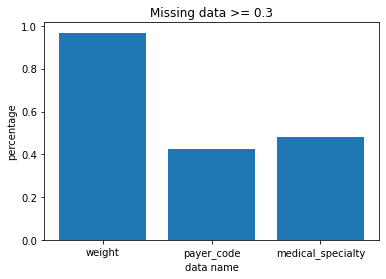

In [2]:
'''
Finding Missing Data
'''
lis = []
names = []
for col in data.columns:
    if data[col].dtype == object:
         if data[col][data[col] == '?'].count()/data.shape[0] > 0.3:
                lis.append(data[col][data[col] == '?'].count()/data.shape[0])
                names.append(col)
plt.bar(names, lis)
plt.xlabel('data name') 
plt.ylabel('percentage') 
plt.title("Missing data >= 0.3")
plt.show() 

In [3]:
data = data.drop(['encounter_id2', 'patient_nbr2'], axis=1) #drop useless columns
# data = data.drop_duplicates(subset= ['patient_nbr2'], keep = 'first') #remove duplicated patients
data = data.drop(['citoglipton', 'examide'], axis=1) #given values are all "No", so they are useless.

In [4]:
data=data.replace('?',np.nan) 

In [5]:
data

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,tolazamide,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,[80-90),NaN,2,1,4,13,NaN,NaN,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
1,Caucasian,Female,[90-100),NaN,3,3,4,12,NaN,InternalMedicine,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
2,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,...,No,Steady,No,No,No,No,No,Ch,Yes,NO
3,AfricanAmerican,Female,[40-50),NaN,1,1,7,9,NaN,NaN,...,No,Steady,No,No,No,No,No,No,Yes,>30
4,Caucasian,Male,[50-60),NaN,2,1,2,3,NaN,NaN,...,No,Steady,No,No,No,No,No,No,Yes,>30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90761,AfricanAmerican,Male,[70-80),NaN,1,3,7,3,MC,NaN,...,No,Down,No,No,No,No,No,Ch,Yes,>30
90762,AfricanAmerican,Female,[80-90),NaN,1,4,5,5,MC,NaN,...,No,Steady,No,No,No,No,No,No,Yes,NO
90763,Caucasian,Male,[70-80),NaN,1,1,7,1,MC,NaN,...,No,Down,No,No,No,No,No,Ch,Yes,NO
90764,Caucasian,Female,[80-90),NaN,2,3,7,10,MC,Surgery-General,...,No,Up,No,No,No,No,No,Ch,Yes,NO


In [6]:
'''
Dealing with Missing Values
'''
label_diag_1 = data[data['diag_1'] == '?'].index.values.tolist()
label_diag_2 = data[data['diag_2'] == '?'].index.values.tolist()
label_diag_3 = data[data['diag_3'] == '?'].index.values.tolist()
label_gender = data[data['gender'] == 'Unknown/Invalid'].index.values.tolist()
labels = list(set(label_diag_1+label_diag_2+label_diag_3+label_gender))
data = data.drop(labels=labels, axis=0)

data['race'].fillna(method ='pad', inplace=True)

In [7]:
data.loc[~data['medical_specialty'].isin(['UNK','InternalMedicine',
        'Emergency/Trauma','Family/GeneralPractice','Cardiology','Surgery-General',
        'Nephrology','Orthopedics','Orthopedics-Reconstructive','Radiologist']),'medical_specialty']='Other'

In [8]:
data['target']=(data['readmitted']=='<30').astype('int')

In [9]:
'''
Feature Engineering
'''
# combining features and reduce/add columns.
data['number_visits'] = data['number_outpatient'] + data['number_emergency'] + data['number_inpatient']
data = data.drop(['number_outpatient', 'number_emergency', 'number_inpatient'], axis=1)
data['total_procedures'] = data['num_lab_procedures'] + data['num_procedures'] 
# data = data.drop(['num_lab_procedures', 'num_procedures'], axis=1)


In [10]:
def modifDiag(name):
    for index, row in tqdm(data.iterrows()):
        if "V" in str(row[name]) or "E" in str(row[name]):
            data.loc[index, name] = 1
        elif 139 >= float(row[name]) >= 1:
            data.loc[index, name] = 2
        elif 239 >= float(row[name]) >= 140:
            data.loc[index, name] = 3
        elif 279 >= float(row[name]) >= 240:
            data.loc[index, name] = 4
        elif 289 >= float(row[name]) >= 280:
            data.loc[index, name] = 5
        elif 319 >= float(row[name]) >= 290:
            data.loc[index, name] = 6
        elif 359 >= float(row[name]) >= 320:
            data.loc[index, name] = 7
        elif 389 >= float(row[name]) >= 360:
            data.loc[index, name] = 8
        elif 459 >= float(row[name]) >= 390:
            data.loc[index, name] = 9
        elif 519 >= float(row[name]) >= 460:
            data.loc[index, name] = 10
        elif 579 >= float(row[name]) >= 520:
            data.loc[index, name] = 11
        elif 629 >= float(row[name]) >= 580:
            data.loc[index, name] = 12
        elif 679 >= float(row[name]) >= 630:
            data.loc[index, name] = 13
        elif 709 >= float(row[name]) >= 680:
            data.loc[index, name] = 14
        elif 739 >= float(row[name]) >= 710:
            data.loc[index, name] = 15
        elif 759 >= float(row[name]) >= 740:
            data.loc[index, name] = 16
        elif 779 >= float(row[name]) >= 760:
            data.loc[index, name] = 17
        elif 799 >= float(row[name]) >= 780:
            data.loc[index, name] = 18
        else:
            data.loc[index, name] = 19

modifDiag('diag_1')
modifDiag('diag_2')
modifDiag('diag_3')

90763it [00:04, 18765.96it/s]
90763it [00:04, 19535.52it/s]
90763it [00:04, 19869.10it/s]


In [11]:
# def modifDiag(name):
#     for index, row in tqdm(data.iterrows()):
#         if "V" in str(row[name]) or "E" in str(row[name]):
#             data.loc[index, name] = 1
#         elif 459 >= float(row[name]) >= 390 | (float(row[name])==785):
#             data.loc[index, name] = 2
#         elif 519 >= float(row[name]) >= 460 | (float(row[name])==786):
#             data.loc[index, name] = 3
#         elif 579 >= float(row[name]) >= 520 | (float(row[name])==787):
#             data.loc[index, name] = 4 
#         elif 629 >= float(row[name]) >= 580 | (float(row[name])==788):
#             data.loc[index, name] = 5
#         elif 999 >= float(row[name]) >= 800:
#             data.loc[index, name] = 6
#         elif 239 >= float(row[name]) >= 140:
#             data.loc[index, name] = 7
#         elif 739 >= float(row[name]) >= 710:
#             data.loc[index, name] = 8
    

# modifDiag('diag_1')
# modifDiag('diag_2')
# modifDiag('diag_3')

In [12]:
data = pd.get_dummies(data, columns=['diag_1', 'diag_2', 'diag_3'], drop_first = True)
data

/Users/Elaine/miniforge3/lib/python3.9/site-packages/pandas/core/algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,diag_3_9,diag_3_10,diag_3_11,diag_3_12,diag_3_13,diag_3_14,diag_3_15,diag_3_16,diag_3_18,diag_3_19
0,Caucasian,Female,[80-90),NaN,2,1,4,13,NaN,Other,...,0,0,0,0,0,0,0,0,0,0
1,Caucasian,Female,[90-100),NaN,3,3,4,12,NaN,InternalMedicine,...,0,1,0,0,0,0,0,0,0,0
2,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,Other,...,0,0,0,0,0,0,0,0,0,0
3,AfricanAmerican,Female,[40-50),NaN,1,1,7,9,NaN,Other,...,0,0,0,0,0,0,0,0,0,1
4,Caucasian,Male,[50-60),NaN,2,1,2,3,NaN,Other,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90761,AfricanAmerican,Male,[70-80),NaN,1,3,7,3,MC,Other,...,1,0,0,0,0,0,0,0,0,0
90762,AfricanAmerican,Female,[80-90),NaN,1,4,5,5,MC,Other,...,0,0,0,0,0,0,0,0,1,0
90763,Caucasian,Male,[70-80),NaN,1,1,7,1,MC,Other,...,0,0,0,0,0,0,0,0,0,0
90764,Caucasian,Female,[80-90),NaN,2,3,7,10,MC,Surgery-General,...,0,0,0,0,0,0,0,0,0,1


In [13]:
# import matplotlib.pyplot as plt

# # make the figure to appropiate size
# plt.figure(figsize=(18,12))

# # draw a heatmap between all columns
# sns.heatmap(data=data.corr().round(2), annot=True);
# plt.show()

In [14]:
data1 = data.drop(columns = "num_lab_procedures", axis = 1)

In [15]:
# data1.hist(figsize=(15,15))
# plt.suptitle("fig.1 Histogram of all features in input training data set");

In [16]:
'''
Shorten the Range
'''
data['discharge_disposition_id'].replace(to_replace=(1, 2, 3, 4, 5, 6, 7, 8, 9), value=(1, 1, 1, 1, 1, 1, 1, 1, 1), inplace=True)
data['discharge_disposition_id'].replace(to_replace=(10, 11, 12, 13, 14, 15, 16, 17, 18), value=(2, 2, 2, 2, 2, 2, 2, 2, 2), inplace=True)
data['discharge_disposition_id'].replace(to_replace=(19, 20, 21, 22, 23, 24, 25, 26, 27, 28), value=(3, 3, 3, 3, 3, 3, 3, 3, 3, 3), inplace=True)
data['admission_source_id'].replace(to_replace=(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 17, 20, 22, 25), value=(1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3), inplace=True)
data['admission_type_id'].replace(to_replace=(1, 2, 3, 4, 5, 6, 7, 8), value=(1, 1, 1, 2, 2, 2, 3, 3), inplace=True)

In [17]:
'''
Tokenization
'''
data['change'].replace(to_replace=('No','Ch'), value=(0, 1), inplace=True)
data['gender'].replace(to_replace=('Female', 'Male'), value=(0, 1), inplace=True) 
data['diabetesMed'].replace(to_replace=('No','Yes'), value=(0, 1), inplace=True)
indexName = data.columns.tolist()
data.replace(to_replace=('No','Steady','Up', 'Down'), value=(0, 0, 1, 1), inplace=True)
data['A1Cresult'].replace(to_replace=('None', '>7', '>8', 'Norm'), value=(-999, 1, 1, 0), inplace=True)
data['max_glu_serum'].replace(to_replace=('None', '>300', 'Norm', '>200'), value=(-999, 1, 0, 1), inplace=True)
data.replace(to_replace=('[90-100)', '[80-90)', '[40-50)', '[50-60)', '[60-70)', '[70-80)',
       '[20-30)', '[10-20)', '[30-40)', '[0-10)'), value=(10, 9, 5, 6, 7, 8, 3, 2, 4, 1), inplace=True)
data['readmitted'].replace(to_replace=('NO','>30','<30'), value=(0, 1, 1), inplace=True) 
# types = tuple(data['race'].unique())
# data['race'].replace(to_replace = types, value = tuple([i for i in range(len(types))]), inplace=True)
data['severity'] = 0
indexName = data.columns.tolist()
for medic in indexName[14:35]:
    data['severity'] = data['severity'] + data[medic]
# data['patient_nbr2'] = data['patient_nbr2'].astype('int64') 
data['payer_code']=data['payer_code'].fillna('UNK') #filling null with unk
data['has_weight']=data['weight'].notnull().astype('int')
data.drop(['weight'],axis=1,inplace=True)

In [18]:
'''
Dummies
'''
data = pd.get_dummies(data, columns=['race', 'gender', 'payer_code', 'medical_specialty', 'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide',
       'nateglinide', 'chlorpropamide', 'glimepiride', 'acetohexamide',
       'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
       'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed'], drop_first = True)
# just_dummies = pd.get_dummies(data['race'])
# data = pd.concat([data, just_dummies], axis=1)      
# data.drop(['race'], inplace=True, axis=1)

In [19]:
# interactionterms = [('num_medications','time_in_hospital'),
# ('num_medications','num_procedures'),
# ('time_in_hospital','num_lab_procedures'),
# ('num_medications','num_lab_procedures'),
# ('num_medications','number_diagnoses'),
# ('age','number_diagnoses'),
# ('change','num_medications'),
# ('number_diagnoses','time_in_hospital'),
# ('num_medications','severity')]
# for inter in interactionterms:
#     name = inter[0] + '|' + inter[1]
#     data[name] = data[inter[0]] * data[inter[1]]


In [20]:
'''
Using Log Transform to remove Skewness.
'''
features = list(set(list(data._get_numeric_data().columns))- {'readmitted'})
for i in features:
    skewval = data[i].skew()
    kurtval = data[i].kurtosis()    
    if (abs(skewval) > 2) & (abs(kurtval) > 2):
        if len(data[data[i] == 0])/len(data) <= 0.02:
            data[i] = np.log(data[i])
        else:
            data[i] = np.log1p(data[i])



In [21]:
# '''
# Standarization
# '''
# indexName = data.columns.tolist()
# for col in indexName:
#     if col != "readmitted":
#         data[col] = preprocessing.StandardScaler().fit_transform(data[[col]].values)
# # data = data[(np.abs(sp.stats.zscore(data[features])) < 3).all(axis=1)]
        

In [22]:
data

,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,readmitted,...,glyburide_1,pioglitazone_1,rosiglitazone_1,acarbose_1,miglitol_1,tolazamide_1,insulin_1,glyburide-metformin_1,change_1,diabetesMed_1
0,9,0.0,0.0,1,13,68,2,28,8,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1,1
1,10,0.0,0.0,1,12,33,3,18,8,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1,1
2,5,0.0,0.0,2,1,51,0,8,5,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1,1
3,5,0.0,0.0,2,9,47,2,17,9,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,1
4,6,0.0,0.0,1,3,31,6,16,9,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90761,8,0.0,0.0,2,3,51,0,16,9,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,1,1
90762,9,0.0,0.0,1,5,33,3,18,9,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,1
90763,8,0.0,0.0,2,1,53,0,9,13,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,1,1
90764,9,0.0,0.0,2,10,45,2,21,9,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,1,1


In [23]:
'''
Spliting Data
'''
features = list(set(list(data.columns))- {'readmitted'})
X = data[features]
y = data['readmitted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X

,tolazamide_1,number_diagnoses,medical_specialty_InternalMedicine,diag_2_13,payer_code_MP,max_glu_serum_1,diag_3_18,diag_1_18,gender_1,diag_3_11,...,diag_1_4,payer_code_PO,admission_type_id,diag_1_7,diag_3_4,medical_specialty_Other,diag_3_9,medical_specialty_Nephrology,diag_3_15,has_weight
0,0.0,8,0,0.0,0.0,0.0,0.000000,0.0,0,0.0,...,0.000000,0.0,0.0,0.0,0,1,0,0.0,0.0,0.0
1,0.0,8,1,0.0,0.0,0.0,0.000000,0.0,0,0.0,...,0.000000,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
2,0.0,5,0,0.0,0.0,0.0,0.000000,0.0,1,0.0,...,0.000000,0.0,0.0,0.0,1,1,0,0.0,0.0,0.0
3,0.0,9,0,0.0,0.0,0.0,0.000000,0.0,0,0.0,...,0.693359,0.0,0.0,0.0,0,1,0,0.0,0.0,0.0
4,0.0,9,0,0.0,0.0,0.0,0.000000,0.0,1,0.0,...,0.000000,0.0,0.0,0.0,1,1,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90761,0.0,9,0,0.0,0.0,0.0,0.000000,0.0,1,0.0,...,0.693359,0.0,0.0,0.0,0,1,1,0.0,0.0,0.0
90762,0.0,9,0,0.0,0.0,0.0,0.693359,0.0,0,0.0,...,0.000000,0.0,0.0,0.0,0,1,0,0.0,0.0,0.0
90763,0.0,13,0,0.0,0.0,0.0,0.000000,0.0,1,0.0,...,0.000000,0.0,0.0,0.0,0,1,0,0.0,0.0,0.0
90764,0.0,9,0,0.0,0.0,0.0,0.000000,0.0,0,0.0,...,0.000000,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0


In [24]:
logit = LogisticRegression(fit_intercept=True, penalty='l2')
logit.fit(X_train, y_train)
logit_pred = logit.predict(X_test)
pd.crosstab(pd.Series(y_test, name = 'Actual'), pd.Series(logit_pred, name = 'Predict'), margins = True)
print("Accuracy is {0:.2f}".format(accuracy_score(y_test, logit_pred)))
print("Precision is {0:.2f}".format(precision_score(y_test, logit_pred)))
print("Recall is {0:.2f}".format(recall_score(y_test, logit_pred)))

accuracy_logit = accuracy_score(y_test, logit_pred)
precision_logit = precision_score(y_test, logit_pred)
recall_logit = recall_score(y_test, logit_pred)

Accuracy is 0.64
Precision is 0.63
Recall is 0.49


/Users/Elaine/miniforge3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(activation='relu', hidden_layer_sizes=(100, ), max_iter=15, alpha=1e-4, batch_size=100,
                    solver='adam', verbose=10, learning_rate_init=.01)
mlp.fit(X_train, y_train)

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import make_classification
# clf = RandomForestClassifier(max_depth=2, random_state=0)
# clf.fit(X_train, y_train)


Iteration 1, loss = 2.86345875
Iteration 2, loss = 0.99307737
Iteration 3, loss = 0.77736572
Iteration 4, loss = 0.63650670
Iteration 5, loss = 0.62125215
Iteration 6, loss = 0.59485239
Iteration 7, loss = 0.58966339
Iteration 8, loss = 0.59536243
Iteration 9, loss = 0.59348298
Iteration 10, loss = 0.58381934
Iteration 11, loss = 0.58530778
Iteration 12, loss = 0.59812060
Iteration 13, loss = 0.60010676
Iteration 14, loss = 0.59314122
Iteration 15, loss = 0.58895494


/Users/Elaine/miniforge3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (15) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(batch_size=100, learning_rate_init=0.01, max_iter=15, verbose=10)

In [26]:
y_pred = mlp.predict(X_test)

In [27]:
from sklearn.metrics import accuracy_score, mean_squared_error, precision_score, recall_score, f1_score
print("########## Test ###########")
print("Accu.:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred, average="macro"))
print("Precision:", precision_score(y_test, y_pred, average="macro"))
print("F1:", f1_score(y_test, y_pred, average="macro"))
print("MSE:", mean_squared_error(y_test, y_pred))

########## Test ###########
Accu.: 0.6868286233680383
Recall: 0.6717369064769962
Precision: 0.697033361733116
F1: 0.6695409930129402
MSE: 0.31317137663196165


/var/folders/k3/dm3pbfdd7ysgk9czg_x952pc0000gn/T/ipykernel_82405/1775116815.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=sns.kdeplot(data.loc[(data['readmitted'] == 0),'time_in_hospital'] , color='b',shade=True,label='Not Readmitted')
/var/folders/k3/dm3pbfdd7ysgk9czg_x952pc0000gn/T/ipykernel_82405/1775116815.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax=sns.kdeplot(data.loc[(data['readmitted'] == 1),'time_in_hospital'] , color='r',shade=True, label='Readmitted')


Text(0.5, 1.0, 'Time in Hospital VS. Readmission')

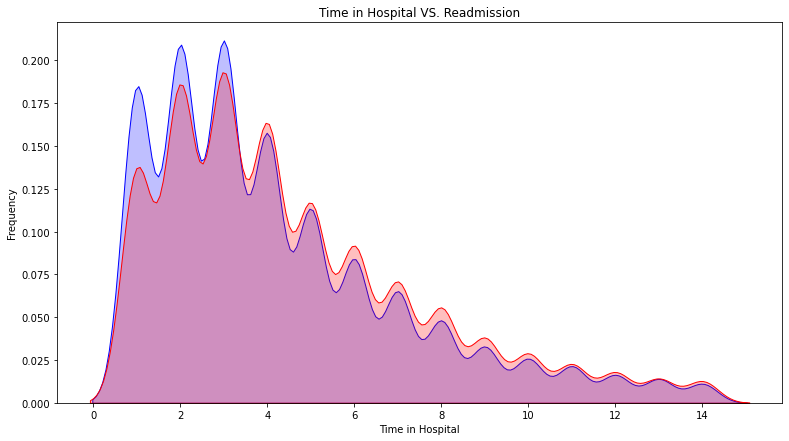

In [28]:
fig = plt.figure(figsize=(13,7),)
ax=sns.kdeplot(data.loc[(data['readmitted'] == 0),'time_in_hospital'] , color='b',shade=True,label='Not Readmitted')
ax=sns.kdeplot(data.loc[(data['readmitted'] == 1),'time_in_hospital'] , color='r',shade=True, label='Readmitted')
ax.set(xlabel='Time in Hospital', ylabel='Frequency')
plt.title('Time in Hospital VS. Readmission')

In [29]:
from sklearn.tree import DecisionTreeClassifier
mlp1 = DecisionTreeClassifier(criterion='entropy',splitter = "best", max_depth=5)
mlp1.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [30]:
y_pred1 = mlp1.predict(X_test)

In [31]:
print("########## Test ###########")
print("Accu.:", accuracy_score(y_test, y_pred1))
print("Recall:", recall_score(y_test, y_pred1, average="macro"))
print("Precision:", precision_score(y_test, y_pred1, average="macro"))
print("F1:", f1_score(y_test, y_pred1, average="macro"))
print("MSE:", mean_squared_error(y_test, y_pred1))

########## Test ###########
Accu.: 0.6811546300886906
Recall: 0.6579490170025717
Precision: 0.7234905433758857
F1: 0.6452519215426211
MSE: 0.3188453699113094


In [32]:
from sklearn.ensemble import RandomForestClassifier
mlp2 = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
mlp2.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, max_features=1, n_estimators=10)

In [33]:
y_pred2 = mlp1.predict(X_test)
print("########## Test ###########")
print("Accu.:", accuracy_score(y_test, y_pred2))
print("Recall:", recall_score(y_test, y_pred2, average="macro"))
print("Precision:", precision_score(y_test, y_pred2, average="macro"))
print("F1:", f1_score(y_test, y_pred2, average="macro"))
print("MSE:", mean_squared_error(y_test, y_pred2))

########## Test ###########
Accu.: 0.6811546300886906
Recall: 0.6579490170025717
Precision: 0.7234905433758857
F1: 0.6452519215426211
MSE: 0.3188453699113094
